# Identify Entity Names

In [17]:
import pandas as pd, json, numpy as np

wcfile = 'wiki/simplewiki-20211120/wordcount.min2.json'
countfile = 'wiki/simplewiki-20211120/count.min2.json'
evalfile = 'evaluation/Mewsli-9/en.tsv'

# wcfile = 'wiki/nlwiki-20220301/wordcount.min2.json'
# countfile = 'wiki/nlwiki-20220301/count.min2.json'
# evalfile = 'evaluation/Mewsli-9/nl.tsv'

wc = pd.read_json(wcfile, orient='index')[0].sort_values()
aec = json.load(open(countfile))
aec = pd.DataFrame([(a,e,c) for a, ec in aec.items() for e,c in ec.items()])
aec[1] = aec[1].str[1:].astype(int)
badent = pd.read_csv('data/wikidata-20211122-disambig+list.txt', header=None)[0]
# aec = aec[~aec[1].isin(badent)]
aec = aec.set_index([0,1])[2]
print( len(wc), len(aec) )


import pandas as pd, json, numpy as np
from minimel import normalize
ev = pd.read_csv('evaluation/Mewsli-9/nl.tsv', header=None, sep='\t')[1]
ev = ev.map(lambda x:[n for surf in json.loads(x) for n in normalize(surf)]).explode()

df = pd.DataFrame({'wc':wc, 'aec':aec.groupby(level=0).sum()}, dtype='Int64').dropna()
df['ratio'] = np.log(df.wc) / np.log(df.aec)

159170 187688


In [18]:
df['ratio'] = np.log(df.wc) / np.log(df.aec * 20)

In [19]:
import tqdm
from minimel.count import count_surface_lines
lines = dict(zip(list(range(250)), open(evalfile))).values()
ev_count = dict(count_surface_lines(tqdm.tqdm(lines, desc='Counting eval words'), countfile))

Counting eval words: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:26<00:00,  9.59it/s]


<AxesSubplot:xlabel='ratio', ylabel='ev_count'>

<AxesSubplot:xlabel='ratio'>

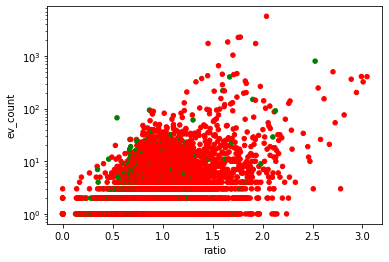

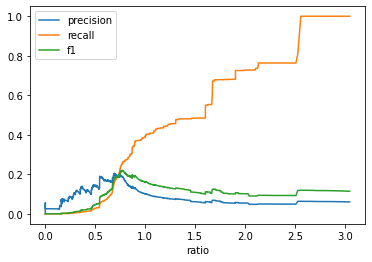

In [20]:
"""
We want a trade-off between accepting bad entities and rejecting good ones.
"""
df2 = df.copy()
df2['ev_count'] = pd.Series(ev_count)
df2['ev_linked'] = df2.index.isin(ev)
df2.dropna(inplace=True)
df2.sort_values('ratio', inplace=True)
df2
display(df2.plot.scatter(x='ratio', y='ev_count', c=df2['ev_linked'].map(lambda x: 'g' if x else 'r'), logy=True))

s = pd.DataFrame({
    'false positives': (df2['ev_count'] * ~df2['ev_linked']).cumsum(),
    'false negatives': (df2['ev_count'] * df2['ev_linked'])[::-1].cumsum()[::-1],
    'true positives': (df2['ev_count'] * df2['ev_linked']).cumsum(),
    'ratio': df2['ratio'],
})
s['precision'] = s['true positives'] / (s['true positives'] + s['false positives'])
s['recall'] = s['true positives'] / (s['true positives'] + s['false negatives'])
s['f1'] = 2 * (s['precision'] * s['recall']) / (s['precision'] + s['recall'])
s.set_index('ratio')[['precision','recall', 'f1']].plot.line()

In [21]:
from IPython.display import HTML
def display_row(captioned_dataframes):
    return HTML(f"""<div style="display:flex; flex-direction: row;">
        {"&nbsp;&nbsp;".join(df.style.set_caption(c)._repr_html_() for c,df in captioned_dataframes.items())}
    </div>""")

cutoff = .75
print('Threshold:', cutoff)
print(f'keeping', len(df[df.ratio < cutoff]), '; dropping', len(df[df.ratio > cutoff]))

drop_ev = set(ev) & set(df[df.ratio > cutoff].index)
print('dropping eval names:', len(drop_ev))
print(drop_ev)

display_row({
    'False Positives': df2[~df2['ev_linked'] & (df2['ratio'] < cutoff)].sort_values('ev_count')[::-1].head(20),
    'False Negatives': df2[df2['ev_linked'] & (df2['ratio'] > cutoff)].sort_values('ev_count')[::-1].head(20),
})

Threshold: 0.75
keeping 145212 ; dropping 13958
dropping eval names: 276
{'marvel', 'whistler', 'apple', 'mohammed', 'branson', 'pence', 'may', 'union', 'ice', 'hualien', 'democratic party', 'president', 'rtl', 'franco', 'goes', 'a9', 'de', 'tesla', 'bart', 'cover', 'chinas', 'queen', 'texas', 'ad', 'bunker', 'xbox', 'or', 'beni', 'hazard', 'rudd', 'miranda', '15 november', 'ortega', '25 november', 'sylvester', 'wikipedia', 'ns', 'japans', 'fifa', 'trinidad', 'is', 'wales', 'shell', 'herbivore', 'new york', 'cohen', 'jury', 'deus', 'circus', 'go', 'new jersey', 'boise', 'maria', 'edwards', 'genie', 'baldwin', 'cleveland', 'tampa', 'november', 'kung fu', 'premier', 'trump', 'sense', 'caucuses', 'philips', '11 september', 'kern', 'princeton', 'nra', 'nintendo', 'manchester', 'salah', 'alliance', 'hash', 'boeing', 'bourbon', 'gatwick', 'wolf', '25 april', 'a6', 'standard', 'a4', 'polisario', 'am', 'prince', 'parkland', 'florida', 'cao', 'change', 'juan carlos', 'clinton', 'cambridge', 'ut

,wc,aec,ratio,ev_count,ev_linked
australia,6109,6647,0.738920,26.000000,False
iraq,803,909,0.681923,26.000000,False
leu,7,2,0.527507,20.000000,False
earthquake,1194,694,0.742809,20.000000,False
israel,2131,2238,0.715687,15.000000,False
climate change,231,178,0.665534,15.000000,False
gaza,158,62,0.710752,14.000000,False
new zealand,2487,1975,0.738737,14.000000,False
united nations,1363,868,0.739346,14.000000,False
france,8471,16668,0.711207,14.000000,False


In [8]:
l = 'stille oceaan'
display(df.loc[l])
if l in aec:
    display(aec[l], l in drop_ev)

wc            9.0
aec        1276.0
ratio    0.216535
Name: stille oceaan, dtype: Float64

1
184425       2
98        1274
Name: 2, dtype: int64

False

In [26]:
from minimel.normalize import normalize
from minimel.vectorize import vw_tok

import json, math, tqdm, dawg
surface_weights = json.load(open(countfile))

# filter out selection
drop_tok = set(tuple(vw_tok(d)) for d in df[df.ratio > cutoff].index)
surface_weights = {k:v for k,v in surface_weights.items() if (tuple(vw_tok(k)) not in drop_tok) and not k[-1]=='-' }

surface_trie = dawg.CompletionDAWG(surface_weights)
import pathlib
surface_trie.save( pathlib.Path(countfile).parent / (pathlib.Path(countfile).stem + '.salient.completiondawg') )

In [10]:
surface_weights['stille oceaan']

{'Q184425': 2, 'Q98': 1274}

In [77]:
def get_matches(surface_trie, text, language=None):
    for normtext in normalize(text, language=language):
        normtoks = vw_tok(normtext)
        for i,tok in enumerate(normtoks):
            for comp in surface_trie.keys(tok):
                comp_toks = vw_tok(comp)
                if normtoks[i:i+len(comp_toks)] == comp_toks:
                    yield comp

                    
import pandas as pd
data = pd.read_csv('evaluation/Mewsli-9/nl.tsv', sep='\t', nrows=10, header=None)
data[1] = data[1].map(json.loads)
_, mention_ent, text = data.iloc[6]
print(text)
print(mention_ent)


for match in get_matches(surface_trie, text):
    # NIL match
    weights = surface_weights[match]
    print(match, weights)
    # for label in vw_label_lines(weights, -1, comp, ent_feats):
    #     labels.append(label)

Zware aardbeving voor de kust in zuiden Mexico  8 september 2017   Zware aardbeving 8.2 voor de kust in zuiden Mexico  De zuidkust van Mexico is omstreeks middernacht plaatselijke tijd getroffen door een aardbeving. De Mexicaanse seismologische dienst zegt dat de beving een kracht van 8.2 op de schaal van Richter had. Het centrum was in de Stille Oceaan, op 70 kilometer diepte, zo'n 100 kilometer ten zuidwesten van Pijijiapan. De meeste doden vielen in Oaxaca en het aangrenzende Chiapas. Ook in buurland Guatemala heeft de beving een dodelijk slachtoffer geëist.  De aardbeving was ook te voelen in Mexico-Stad, waar mensen in paniek de straat op renden. De aardbeving zorgde even voor een grootschalige stroomuitval bij 1 miljoen mensen, die snel weer kon worden verholpen. De beving veroorzaakte ook een lichte tsunami.  Een dergelijke krachtige aardbeving komt gemiddeld één keer per jaar voor. De vorige van dit kaliber was in 2015, in Chili. De laatste zware aardbeving in Mexico (waarbij v

In [75]:
df2.loc['op de rails']

wc            1.0
aec          59.0
ratio         0.0
ev_count      2.0
ev_linked     0.0
Name: op de rails, dtype: Float64

In [5]:
from minimel.vectorize import vw
import pathlib
fname = 'wiki/nlwiki-20220301/experiments/clean-q0.25.json'
vw(['id\t{"amsterdam": 9899}\tik ging naar amsterdam en Rotterdam'], pathlib.Path(fname))

['shared |s ik ging naar amsterdam en rotterdam',
 '9899:0 |l amsterdam=9899 ',
 '727:1 |l amsterdam=727 ',
 '478771:1 |l amsterdam=478771 ',
 '50719:1 |l amsterdam=50719 ',
 '2060132:1 |l amsterdam=2060132 ',
 '214341:1 |l amsterdam=214341 ',
 '194215:1 |l amsterdam=194215 ',
 '26674641:1 |l amsterdam=26674641 ',
 '1127380:1 |l amsterdam=1127380 ',
 '9694:1 |l amsterdam=9694 ',
 '2691069:1 |l amsterdam=2691069 ',
 '2393888:1 |l amsterdam=2393888 ',
 '478785:1 |l amsterdam=478785 ',
 '1397383:1 |l amsterdam=1397383 ',
 '122781:1 |l amsterdam=122781 ',
 '959016:1 |l amsterdam=959016 ',
 '5715626:1 |l amsterdam=5715626 ',
 '2060246:1 |l amsterdam=2060246 ',
 '4748823:1 |l amsterdam=4748823 ',
 '2049529:1 |l amsterdam=2049529 ',
 '95630476:1 |l amsterdam=95630476 ',
 '683829:1 |l amsterdam=683829 ',
 '478456:1 |l amsterdam=478456 ',
 '4549041:1 |l amsterdam=4549041 ',
 '13427674:1 |l amsterdam=13427674 ',
 '585429:1 |l amsterdam=585429 ',
 '505639:1 |l amsterdam=505639 ',
 '2276292:1 |l a